In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUBP13Q/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUBP13Q/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUBP13Q/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = dataset['train'], dataset['test']
BUFFER_SIZE = 10000 #untuk mengacak2 kata2 (untuk menghindari bias)
BATCH_SIZE = 64 #panjang sequence

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
#text encoder untuk mengubah text kedalam nilai numerik
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))




In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Dropout, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])





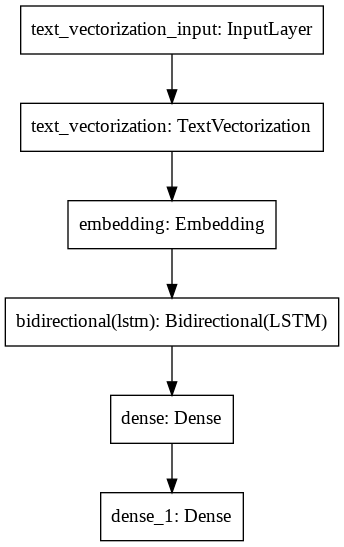

In [5]:
tf.keras.utils.plot_model(model)


In [6]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=test_data,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 110s 248ms/step - loss: 0.6256 - accuracy: 0.5921 - val_loss: 0.4974 - val_accuracy: 0.7323
Epoch 2/10
391/391 [==============================] - 93s 235ms/step - loss: 0.4261 - accuracy: 0.8026 - val_loss: 0.4628 - val_accuracy: 0.7932
Epoch 3/10
391/391 [==============================] - 91s 230ms/step - loss: 0.3726 - accuracy: 0.8315 - val_loss: 0.3552 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3344 - accuracy: 0.8542 - val_loss: 0.3395 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 91s 231ms/step - loss: 0.3212 - accuracy: 0.8608 - val_loss: 0.3318 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3111 - accuracy: 0.8677 - val_loss: 0.3335 - val_accuracy: 0.8448
Epoch 7/10
391/391 [==============================] - 95s 240ms/step - loss: 0.3069 - accuracy: 0.8688 - val_loss: 0.3205 - val_a

In [7]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 48s 123ms/step - loss: 0.3177 - accuracy: 0.8574
Test Loss: 0.31768667697906494
Test Accuracy: 0.8573600053787231


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()



In [ ]:
def review_padding(encoded_review, padding_size):
    zeros = [0] * (padding_size - len(encoded_review))
    encoded_review.extend(zeros)
    return encoded_review

def review_encoder(review):
    encoded_review = review_padding(encoder.encode( review ), 64)
    encoded_review = tf.cast( encoded_review,  tf.float32)
    return tf.expand_dims( encoded_review, 0)

fight_club_review = 'It has some cliched moments, even for its time, \
but FIGHT CLUB is an awesome film. I have watched it \
about 100 times in the past 20 years. It never gets old. It \
is hard to discuss this film without giving things away but \
suffice it to say, it is a great thriller with some intriguing \
twists.'

model.predict(review_encoder(fight_club_review)) #positif artinya bagus (>0.5). negatif jeleg (<0.5)


In [ ]:
any_movie = 'The movie was not good. The animation and the graphics \
             were terrible. I would not recommend this movie.'

model.predict(review_encoder(any_movie))


In [ ]:
mission_impossible_review = 'Worst movie!'

model.predict(review_encoder(mission_impossible_review)) #ini ada bias, yg jadi kelemahan model kita
#cara ngehandlenya: dicoba cara lain dengan text vectorization (encoding dan decoding data2 nya)


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

any_movie = ('Terrible movie!')
predictions2 = model.predict(np.array([any_movie]))
print(predictions2)

pos_movie = (‘Awesome movie!')
predictions3 = model.predict(np.array([pos_movie]))
print(predictions3)
